In [17]:
import time
import warnings
import numpy as np
import pandas as pd
import math
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, r2_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, mean_squared_error, mean_absolute_error, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

### Load the data

In [2]:
df = pd.DataFrame(pd.read_csv("global.csv"))
df.head()

,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,date,hour,date-time,dvs24
0,EP011982,1982,25,546,-20.0,10.0,-28.0,22.0,-23.0,20.0,...,-50.0,56.0,293.0,77.0,3511.0,0.786585,20-05-1982,00:00:00,20-05-1982 00:00,5.004258
1,EP011982,1982,25,621,-15.0,10.0,-31.0,21.0,-21.0,19.0,...,-58.0,53.0,293.0,67.0,3503.0,0.786585,20-05-1982,06:00:00,20-05-1982 06:00,5.004258
2,EP011982,1982,25,567,-20.0,10.0,-21.0,18.0,-20.0,17.0,...,-7.0,69.0,293.0,64.0,3497.0,0.000000,20-05-1982,12:00:00,20-05-1982 12:00,5.004258
3,EP011982,1982,25,605,-15.0,10.0,-25.0,17.0,-19.0,15.0,...,-54.0,77.0,293.0,36.0,3504.0,0.000000,20-05-1982,18:00:00,20-05-1982 18:00,10.008517
4,EP011982,1982,30,585,-10.0,15.0,-17.0,12.0,-12.0,12.0,...,-72.0,107.0,294.0,59.0,3520.0,5.004258,21-05-1982,00:00:00,21-05-1982 00:00,10.008517


In [3]:
df.drop(columns = ['date', 'hour', 'date-time'], axis = 1, inplace = True)
df.head()

,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,dvs24
0,EP011982,1982,25,546,-20.0,10.0,-28.0,22.0,-23.0,20.0,...,12.0,14.0,-67.0,-50.0,56.0,293.0,77.0,3511.0,0.786585,5.004258
1,EP011982,1982,25,621,-15.0,10.0,-31.0,21.0,-21.0,19.0,...,30.0,50.0,-69.0,-58.0,53.0,293.0,67.0,3503.0,0.786585,5.004258
2,EP011982,1982,25,567,-20.0,10.0,-21.0,18.0,-20.0,17.0,...,27.0,43.0,-11.0,-7.0,69.0,293.0,64.0,3497.0,0.000000,5.004258
3,EP011982,1982,25,605,-15.0,10.0,-25.0,17.0,-19.0,15.0,...,23.0,31.0,-41.0,-54.0,77.0,293.0,36.0,3504.0,0.000000,10.008517
4,EP011982,1982,30,585,-10.0,15.0,-17.0,12.0,-12.0,12.0,...,5.0,13.0,-76.0,-72.0,107.0,294.0,59.0,3520.0,5.004258,10.008517


In [4]:
#create a list of all features
# Target is dvs24
feat = df.columns.to_list()
print(len(feat))

124


In [12]:
#select the basin
select_basin = 'Indian'

#create a dictionary of cell range index of the basins
d = {
    'Western Pacific': '26616:44660',
    'Atlantic': '44660:55370',
    'Indian': '13399:15778',
    'Eastern Pacific': '0:13397'
}

# Extracting start and end indices from the dictionary based on the selected basin
start_idx, end_idx = map(int, d[select_basin].split(':'))

In [13]:
df1 = df.iloc[start_idx : end_idx][feat]
print("Selected basin:", select_basin)
df1.head()

Selected basin: Indian


,name,year,vs0,PSLV_v2,PSLV_v3,PSLV_v4,PSLV_v5,PSLV_v6,PSLV_v7,PSLV_v8,...,HE07_t24,HE05_t24,O500_t24,O700_t24,CFLX_t24,CSST_t24,V20C_t24,E000_t24,DELV-12,dvs24
13399,IO021990,1990,30,476,-25.0,5.0,-10.0,8.0,-14.0,6.0,...,-12.0,-20.0,-143.0,-116.0,52.0,300.0,67.0,3564.0,5.004258,15.012775
13400,IO021990,1990,35,484,-28.0,15.0,-13.0,6.0,-17.0,8.0,...,-19.0,-17.0,-170.0,-150.0,23.0,300.0,81.0,3571.0,10.008517,15.012775
13401,IO021990,1990,35,494,-23.0,18.0,-11.0,5.0,-15.0,10.0,...,-18.0,-11.0,-130.0,-101.0,-9.0,300.0,106.0,3582.0,5.004258,20.017033
13402,IO021990,1990,40,543,-18.0,13.0,-15.0,10.0,-15.0,11.0,...,-17.0,-16.0,-173.0,-144.0,48.0,301.0,85.0,3572.0,5.004258,20.017033
13403,IO021990,1990,45,556,-20.0,5.0,-16.0,13.0,-17.0,9.0,...,-3.0,-8.0,-160.0,-127.0,46.0,301.0,123.0,3564.0,10.008517,25.021292


In [14]:
print(f'Range of years: {df1["year"].min()} - {df1["year"].max()}')
print(df1.shape)

Range of years: 1990 - 2017
(2379, 124)


### Load the features file (20, 40 or 60 features)

In [15]:
best_feat = pd.read_csv("best_20_rf_indian.csv")  # change csv file name here
best_feat = list(best_feat.iloc[:, 1].values)
best_feat += ['dvs24']    # appending the target label
print(best_feat)

['DELV-12', 'RSST_t24', 'SHGC_t24', 'SHDC_t24', 'SHRD_t24', 'vs0', 'SHRG_t24', 'VMPI_t24', 'V300_t24', 'MTPW_v10', 'DTL_t24', 'U200_t24', 'TWXC_t24', 'CSST_t24', 'ENEG_t24', 'TWAC_t24', 'SHTS_t24', 'MTPW_v18', 'E000_t24', 'U20C_t24', 'dvs24']


In [16]:
import warnings
warnings.filterwarnings("ignore")

### Creating Leave-three-year-out folds

In [ ]:
years = df1['year'].unique()  # Get unique years from the 'year' column

train_test_data = []  # List to store training and testing datasets

for i in range(0, len(years) - 2, 3):  # Loop over the range up to len(years)-2
    test_years = years[i : i + 3]  # Three consecutive years as testing years
    train_years = np.setdiff1d(years, test_years)  # All other years as training years

    train_data = df1[df1['year'].isin(train_years)]  # Training data
    test_data = df1[df1['year'].isin(test_years)]  # Testing data

    train_data = train_data.drop(['name', 'year'], axis = 1)
    test_data = test_data.drop(['name', 'year'], axis = 1)

    train_test_data.append((train_data, test_data))

### Train the model 

In [29]:
ri_threshold = 30   # adjust RI threshold
features_to_use = best_feat   # set the number of features to retain (either the file loaded before or all 121 features)

list_f1, list_pod, list_far, list_hss, list_pss, list_bs  = [[] for _ in range(6)]

for i in range(len(train_test_data)):
    train_data, test_data = train_test_data[i]

    # Access the training and testing datasets for the current iteration
    X_train_initial = train_data[features_to_use].values     
    X_train = np.delete(X_train_initial, list(features_to_use).index('dvs24'), axis = 1)  
    y_train = train_data['dvs24'].values  

    X_test_initial = test_data[features_to_use].values    
    X_test = np.delete(X_test_initial, list(features_to_use).index('dvs24'), axis = 1)
    y_test = test_data['dvs24'].values
    
    #FEATURE SCALING AND TARGET ENCODING
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)         # input data scaling
    y_train = np.where(y_train >= ri_threshold, 1, 0)      # target feature (dvs24) encoding to 0 and 1

    unri = np.where(y_train < 1)
    ri = np.where(y_train > 0)
    a, b = y_train[unri], y_train[ri]

    X_test_scaled = scaler.fit_transform(X_test)           # input test data scaling
    y_test = np.where(y_test >= ri_threshold, 1, 0)        # target label encoding


    # SMOTE 
    sm = SMOTE(random_state = 42, k_neighbors = 10, sampling_strategy = {0: len(a), 1: round(0.60 * len(a))})                          
    xs, ys = sm.fit_resample(X_train_scaled, y_train)

    # SVC 
    if select_basin == 'Atlantic':
        svc = SVC(kernel = 'rbf', gamma = 0.001, C = 15, verbose = False)
    elif select_basin == 'Indian':
        svc = SVC(kernel = 'rbf', gamma = 0.0005, C = 5, verbose = False)
        
    classifier = svc.fit(xs, ys)
      
    # GETTING PROBABILITIES BY SVC
    calibrated_classifier = CalibratedClassifierCV(classifier, method = 'sigmoid', cv = 'prefit') # Calibration using Platt scaling
    calibrated_classifier.fit(xs, ys)
    probabilities = calibrated_classifier.predict_proba(X_test_scaled)[:, 1]     # Obtain calibrated probabilities
    rounded_probabilities = np.round(probabilities, 3)
    ypredict = (probabilities >= 0.5).astype(int)     # Threshold probabilities to get binary predictions
    
    # OUTPUT METRICS
    f1 = f1_score(y_test, ypredict, zero_division = 0)    # Calculate F1 score with zero_division parameter
    cm = confusion_matrix(y_test, ypredict)
    tp, tn, fp, fn = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    pod = tp / (tp + fn)                                              
    far = fp / (tp + fp)
    pofd = fp / (fp + tn)
    hss = 2 * ((tp*tn) - (fn*fp)) / ((tp+fn)*(fn+tn)+(tp+fp)*(fp+tn))
    pss = pod - pofd

    list_f1.append(f1)
    list_pod.append(pod)
    list_far.append(far)
    list_hss.append(hss)
    list_pss.append(pss)
    
    print('\nFold',i + 1, 'F1:', f1, 'POD:', pod, 'FAR:', far, 'HSS:', hss, 'PSS:', pss)

Fold 1 F1 score: 0.36 POD: 1.0 FAR: 0.7804878048780488 HSS: 0.32592699466166497 PSS: 0.8869257950530035
Fold 2 F1 score: 0.4444444444444444 POD: 0.7142857142857143 FAR: 0.6774193548387096 HSS: 0.37898737613682637 PSS: 0.5900253592561285
Fold 3 F1 score: 0.06818181818181819 POD: 0.16666666666666666 FAR: 0.9571428571428572 HSS: -0.004652605459057072 PSS: -0.011052166224580023
Fold 4 F1 score: 0.5625 POD: 0.6923076923076923 FAR: 0.5263157894736842 HSS: 0.497907949790795 PSS: 0.5988497483824586
Fold 5 F1 score: 0.27586206896551724 POD: 0.5714285714285714 FAR: 0.8181818181818182 HSS: 0.24413145539906103 PSS: 0.4982578397212543
Fold 6 F1 score: 0.6 POD: 1.0 FAR: 0.5714285714285714 HSS: 0.5512572533849129 PSS: 0.8878504672897196
Fold 7 F1 score: 0.4583333333333333 POD: 0.5238095238095238 FAR: 0.5925925925925926 HSS: 0.39316783365160196 PSS: 0.44340751375927256
Fold 8 F1 score: 0.358974358974359 POD: 1.0 FAR: 0.78125 HSS: 0.32602959733853387 PSS: 0.8903508771929824
Fold 9 F1 score: 0.419354838

In [30]:
# Average metrics across all folds

new_list_pod = [item for item in list_pod if item is not None and not math.isnan(item)]
new_list_far = [item for item in list_far if item is not None and not math.isnan(item)]
new_list_hss = [item for item in list_hss if item is not None and not math.isnan(item)]
new_list_pss = [item for item in list_pss if item is not None and not math.isnan(item)]
print('Average POD:', round(sum(new_list_pod) / len(new_list_pod), 3))
print('Average FAR:', round(sum(new_list_far) / len(new_list_far), 3))
print('Average F1 score:', round(sum(list_f1) / len(list_f1), 3))
print('Average HSS:', round(sum(list_hss) / len(list_hss), 3))
print('Average PSS:', round(sum(list_pss) / len(list_pss), 3))

Average POD: 0.715
Average FAR: 0.713
Average F1 score: 0.394
Average HSS: 0.342
Average PSS: 0.603


### Compute SHAP values

In [33]:
# Specifying that we're dealing with just the last fold (years 2015-17) of the data
last_fold = train_test_data[-1]
train_data, test_data = last_fold

# Accessing the training and testing datasets for the last fold
X_train_initial = train_data[best_feat].values
X_train = np.delete(X_train_initial, list(best_feat).index('dvs24'), axis = 1)
y_train = train_data['dvs24'].values

X_test_initial = test_data[best_feat].values
X_test = np.delete(X_test_initial, list(best_feat).index('dvs24'), axis = 1)
y_test = test_data['dvs24'].values

# Generating background data for SHAP computation
X_sample = shap.utils.sample(xs, int(0.1 * len(xs)))   # set as 10% the training data size
random_indices = np.random.choice(X_test_scaled.shape[0], size = X_test_scaled.shape[0] // 2, replace = False) # another set (optional)
X_test_scaled_subset = X_test_scaled[random_indices]

explainer = shap.Explainer(classifier.predict, X_sample)
shap_values = explainer(X_test_scaled)   # or X_test_scaled_subset
print(shap_values)

Permutation explainer: 281it [15:06,  3.27s/it]                                                                 

.values =
array([[ 0.00125   , -0.16      , -0.06166667, ..., -0.00458333,
        -0.01166667,  0.01      ],
       [-0.03541667, -0.15      , -0.04958333, ...,  0.0025    ,
        -0.00791667,  0.00958333],
       [-0.0825    , -0.11791667, -0.04333333, ...,  0.00083333,
        -0.00791667,  0.00708333],
       ...,
       [-0.05291667, -0.0825    , -0.03083333, ...,  0.01708333,
        -0.00666667, -0.00416667],
       [-0.02375   , -0.0775    , -0.05291667, ...,  0.01541667,
        -0.00875   , -0.00208333],
       [-0.03333333, -0.08458333, -0.06      , ...,  0.01916667,
        -0.00833333, -0.01625   ]])

.base_values =
array([0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43,
       0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.

In [35]:
# csv export of computed shap values
shap_values_df = pd.DataFrame(shap_values.values)
shap_values_df.to_csv('shap_values_indian_may.csv', index = False)   # change file name as per basin here

### SHAP summary plot

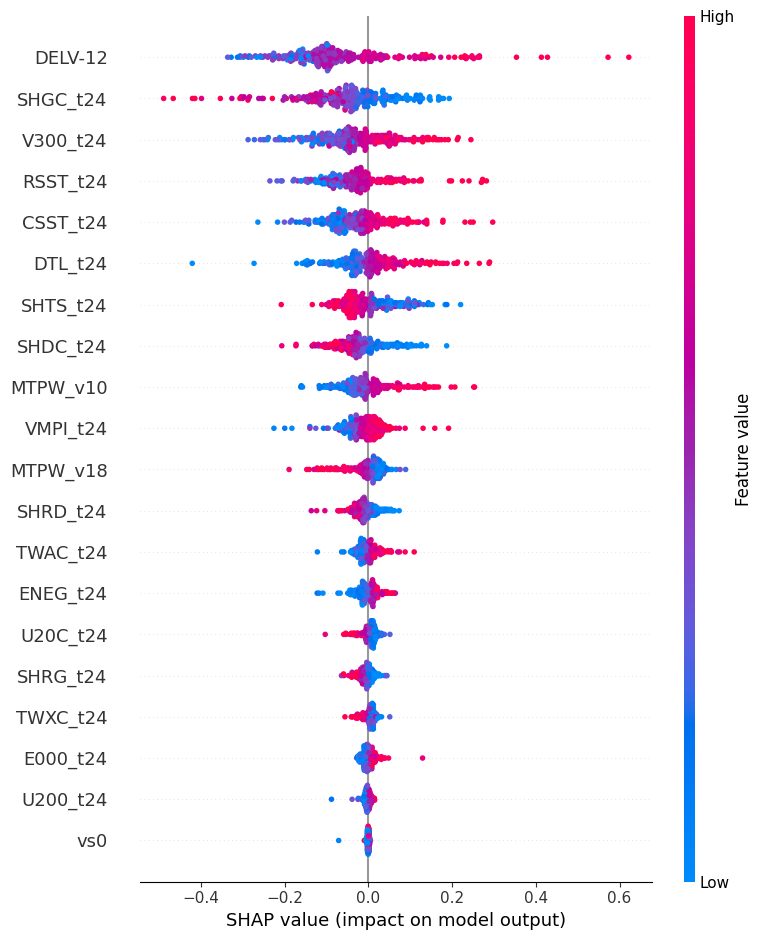

In [36]:
shap.summary_plot(shap_values, X_test_scaled, feature_names = best_feat)

In [37]:
# Converting test data back to original scale
X_test_unscaled = scaler.inverse_transform(X_test_scaled)

In [38]:
# csv export of test data for convenience
x_test_atlantic = pd.DataFrame(X_test_unscaled)
x_test_atlantic.to_csv('xtest_indian_may.csv', index = False)  # change file name as per basin here

### SHAP dependence plots for each feature

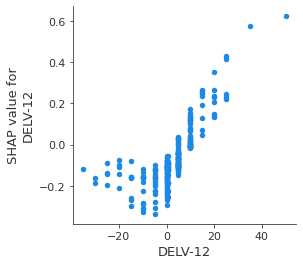

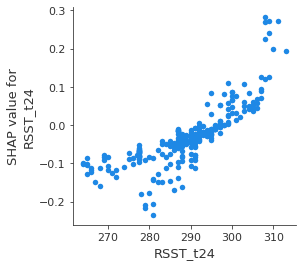

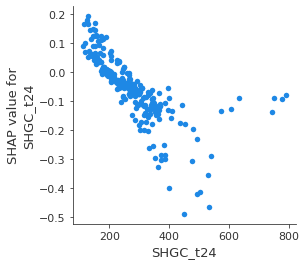

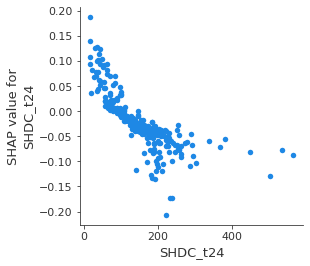

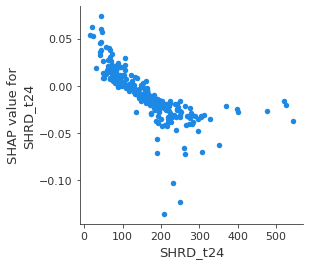

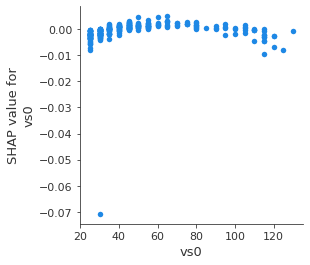

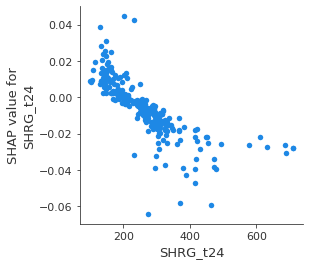

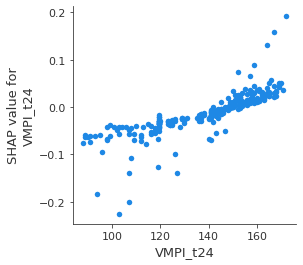

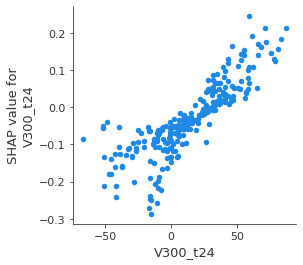

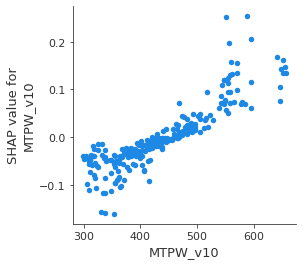

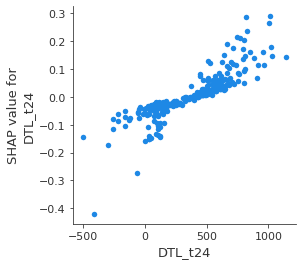

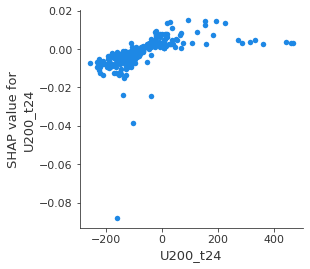

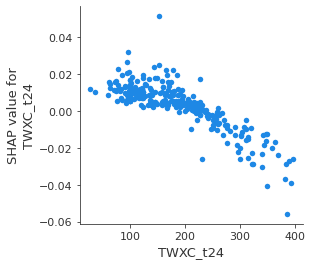

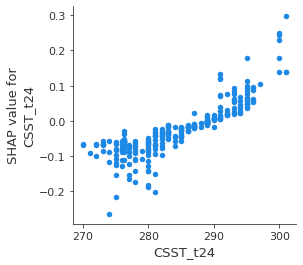

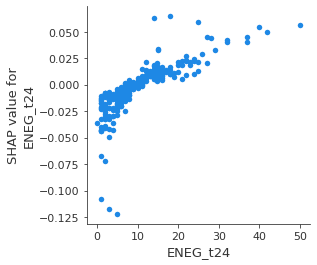

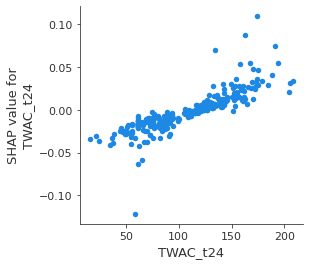

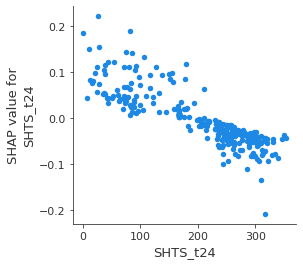

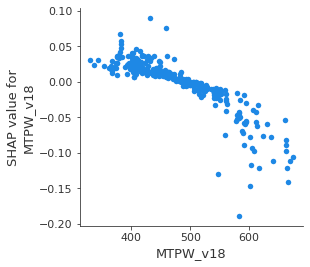

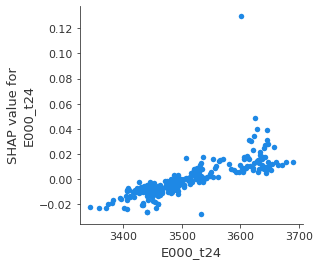

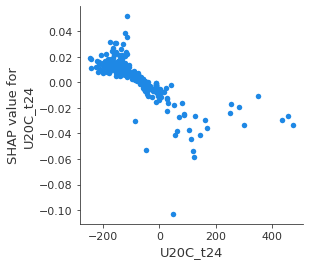

In [18]:
shap_values_array = pd.read_csv("shap_values_indian_may.csv")
unscaled_values = pd.read_csv("xtest_indian_may.csv")

for feature in best_feat:
    if feature != 'dvs24':
        fig, ax = plt.subplots(figsize = (4, 4))
        index = best_feat.index(feature)
        shap.dependence_plot(index,
                             shap_values_array.values,
                             unscaled_values,
                             feature_names = best_feat,
                             dot_size = 30,
                             interaction_index = None , ax = ax)
        
        fig.tight_layout()
        #fig.savefig(str(feature) + '_ind.jpg', dpi = 800)
        plt.show()